**Reinforcement Learning with TensorFlow & TRFL: Actor-Critic Networks**

Outline:
1. Actor-Critic Networks
* Discrete A2C TRFL Loss: trfl.sequence_advantage_actor_critic_loss()
* Continuous A2C TRFL Loss: trfl.sequence_a2c_loss()




In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

    100% |████████████████████████████████| 83.1MB 242kB/s 
    100% |████████████████████████████████| 3.1MB 9.7MB/s 
  Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [1]:
#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

#install TRFL
!pip install trfl

#install box2d for LunarLanding env
!pip install box2d-py


    100% |████████████████████████████████| 686kB 18.3MB/s 
  Found existing installation: tensorflow-probability 0.6.0
    Uninstalling tensorflow-probability-0.6.0:
      Successfully uninstalled tensorflow-probability-0.6.0
    100% |████████████████████████████████| 81kB 3.0MB/s 
    100% |████████████████████████████████| 450kB 7.2MB/s 


In [0]:
import gym
import tensorflow as tf
import trfl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

** Actor-Critic Architecture **

Actor-critic (AC) combines PG and state value methods. Actor-critic has an actor network for policies and a critic network for estimating state values.  The environment produces an observation of the state. The state is inputted into the policy network to select an action. The agent receives a reward and next state. The agent uses the critic network, reward and next state to evaluate the action. The actor and critic networks are updated using that evaluation, typically with gradient descent. The process is similar to REINFORCE with baselines the key difference being the critic network bootstraps using the next state.

** Example 1: Discrete AC **

In [0]:
# set up Actor and Critic networks

class ActorCriticNetwork:
  def __init__(self, name, obs_size=2, action_size=2, actor_hidden_size=32, ac_learning_rate=0.001, 
               entropy_cost=0.01, normalise_entropy=True, lambda_=0., baseline_cost=1.):
    
    with tf.variable_scope(name):
      # hyperparameter bootstrap_n determines the batch size
      self.name=name
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.action_ = tf.placeholder(tf.int32, [None, 1], name='action')
      self.reward_ = tf.placeholder(tf.float32, [None, 1], name='reward')
      self.discount_ = tf.placeholder(tf.float32, [None, 1], name='discount')
      self.bootstrap_ = tf.placeholder(tf.float32, [None], name='bootstrap')

      # set up actor network
      self.fc1_actor_ = tf.contrib.layers.fully_connected(self.input_, actor_hidden_size, activation_fn=tf.nn.elu)
      self.fc2_actor_ = tf.contrib.layers.fully_connected(self.fc1_actor_, actor_hidden_size, activation_fn=tf.nn.elu)
      self.fc3_actor_ = tf.contrib.layers.fully_connected(self.fc2_actor_, action_size, activation_fn=None)
      # reshape the policy logits
      self.policy_logits_ = tf.reshape(self.fc3_actor_, [-1, 1, action_size] )
  
      # generate action probabilities for taking actions
      self.action_prob_ = tf.nn.softmax(self.fc3_actor_)
      
      # set up critic network
      self.fc1_critic_ = tf.contrib.layers.fully_connected(self.input_, critic_hidden_size, activation_fn=tf.nn.elu)
      self.fc2_critic_ = tf.contrib.layers.fully_connected(self.fc1_critic_, critic_hidden_size, activation_fn=tf.nn.elu)
      self.baseline_ = tf.contrib.layers.fully_connected(self.fc2_critic_, 1, activation_fn=None)
      
      # TRFL usage
      self.seq_aac_return_ = trfl.sequence_advantage_actor_critic_loss(self.policy_logits_, self.baseline_, self.action_,
               self.reward_, self.discount_, self.bootstrap_, lambda_=lambda_, entropy_cost=entropy_cost, 
               baseline_cost=baseline_cost, normalise_entropy=normalise_entropy)
      
      # Optimize the loss
      self.ac_loss_ = tf.reduce_mean(self.seq_aac_return_.loss)
      self.ac_optim_ = tf.train.AdamOptimizer(learning_rate=ac_learning_rate).minimize(self.ac_loss_)
      
  def get_network_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]
    

** TRFL Usage: Discrete AC with trfl.sequence_advantage_actor_critic_loss **

Sequence advantage actor critic loss is the discrete implementation of A2C loss. The policy logits and action arguments are the same as other PG usage we have seen this section. The arguments: baseline, reward, discount, and bootstrap, and lambda are used to calculate the advantage. Entropy cost and normalize entropy is the trfl.discrete_policy_entropy_loss function from last video. baseline_cost is an optional argument that lets you scale the derivative amount between the actor network and the critic network.

Since trfl.sequence_advantage_actor_critic_loss() uses trfl.discrete_policy_gradient_loss() we need to reshape the policy_logits before inputting them into the tensor.



In [0]:
# hyperparameters
train_episodes = 5000    
discount = 0.99

actor_hidden_size = 32
critic_hidden_size = 32
ac_learning_rate = 0.0005
baseline_cost = 10. #scale derivatives between actor and critic networks

# entropy hyperparameters
entropy_cost = 0.005
normalise_entropy = True

# one step returns ie TD(0). Section 4 will cover multi-step returns
lambda_ = 0.

seed = 31
env = gym.make('LunarLander-v2')
env.seed(seed)
np.random.seed(seed)
action_size = env.action_space.n
obs_size = env.observation_space.shape[0]

tf.reset_default_graph()
tf.set_random_seed(seed)
ac_net = ActorCriticNetwork(name='ac_net', obs_size=obs_size, action_size=action_size, actor_hidden_size=actor_hidden_size,
                           ac_learning_rate=ac_learning_rate, entropy_cost=entropy_cost, normalise_entropy=normalise_entropy,
                            lambda_=lambda_, baseline_cost=baseline_cost)

ac_target_net = ActorCriticNetwork(name='ac_target_net', obs_size=obs_size, action_size=action_size, actor_hidden_size=actor_hidden_size,
                           ac_learning_rate=ac_learning_rate, entropy_cost=entropy_cost, normalise_entropy=normalise_entropy,
                            lambda_=lambda_, baseline_cost=baseline_cost)

target_network_update_op = trfl.update_target_variables(ac_target_net.get_network_variables(), 
                                                         ac_net.get_network_variables(), tau=0.001)



** TRFL Usage **

We create a target net and use trfl.update_target_variables as we saw in Section 2. We enter a lambda_ value for the trfl.td_lambda function which is called internally. Next section we'll go over multi-step bootstrapping with trfl.td_lambda().

In [6]:
stats_rewards_list = []
stats_every = 10
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
        total_reward, ep_length, done = 0, 0, 0
        stats_actor_loss, stats_critic_loss = 0., 0.
        total_loss_list, action_list, action_prob_list, bootstrap_list = [], [], [], []
        state = np.clip(env.reset(), -1., 1.)
        
        if len(stats_rewards_list) > 10 and np.mean(stats_rewards_list[-10:],axis=0)[1] > 200:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(stats_rewards_list[-10:],axis=0)[1]))
          break
          
        while not done:
            
            # generate action probabilities from policy net and sample from the action probs
            action_probs = sess.run(ac_net.action_prob_, feed_dict={ac_net.input_: np.expand_dims(state,axis=0)})
            action_probs = action_probs[0]
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            next_state, reward, done, info = env.step(action)
            next_state = np.clip(next_state,-1.,1.)
            total_reward += reward
            #reward *= .01
            ep_length += 1

            if done:
              bootstrap_value = np.zeros((1,),dtype=np.float32)
            else:
              #get bootstrap value 
              bootstrap_value = sess.run(ac_target_net.baseline_, feed_dict={
                  ac_target_net.input_: np.expand_dims(next_state, axis=0)
              })
            
            #train network
            _, total_loss, seq_aac_return = sess.run([ac_net.ac_optim_, ac_net.ac_loss_, ac_net.seq_aac_return_], feed_dict={
                ac_net.input_: np.expand_dims(state, axis=0),
                ac_net.action_: np.reshape(action, (-1, 1)),
                ac_net.reward_: np.reshape(reward, (-1, 1)),
                ac_net.discount_: np.reshape(discount, (-1, 1)),
                ac_net.bootstrap_: np.reshape(bootstrap_value, (1,)) #np.expand_dims(bootstrap_value, axis=0)
            })
            total_loss_list.append(total_loss)
            
            #update target network
            sess.run(target_network_update_op)
            
            #some useful things for debuggin
            stats_actor_loss += np.mean(seq_aac_return.extra.policy_gradient_loss)
            stats_critic_loss += np.mean(seq_aac_return.extra.baseline_loss)
            action_list.append(action)
            bootstrap_list.append(bootstrap_value)
            action_prob_list.append(action_probs)
            
            if total_reward < -250:
              done = 1
              
            if done:
              if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                      'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                      'Ep length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                      'Loss: {:4f}'.format(np.mean(total_loss_list)))
                      #'Actor loss: {:.5f}'.format(stats_actor_loss),
                      #'Critic loss: {:.5f}'.format(stats_critic_loss))
                #print(np.mean(bootstrap_value), np.mean(action_list), np.mean(action_prob_list,axis=0))
              stats_actor_loss, stats_critic_loss = 0, 0
              total_loss_list = []
              stats_rewards_list.append((ep, total_reward, ep_length))
              break
              
            state = next_state
         

Episode: 10 Total reward: -182.0 Ep length: 133.1 Loss: 243.055679
Episode: 20 Total reward: -163.9 Ep length: 174.8 Loss: 344.624786
Episode: 30 Total reward: -175.9 Ep length: 187.2 Loss: 245.933304
Episode: 40 Total reward: -144.2 Ep length: 262.0 Loss: 300.059235
Episode: 50 Total reward: -175.5 Ep length: 181.5 Loss: 254.582825
Episode: 60 Total reward: -149.3 Ep length: 191.9 Loss: 293.180969
Episode: 70 Total reward: -131.7 Ep length: 183.1 Loss: 24.662895
Episode: 80 Total reward: -42.0 Ep length: 443.0 Loss: 127.832695
Episode: 90 Total reward: -124.1 Ep length: 373.7 Loss: 71.315628
Episode: 100 Total reward: -116.4 Ep length: 254.4 Loss: 45.214577
Episode: 110 Total reward: -21.4 Ep length: 310.0 Loss: 81.939529
Episode: 120 Total reward: -45.6 Ep length: 322.0 Loss: 89.006477
Episode: 130 Total reward: 7.6 Ep length: 357.8 Loss: 71.663628
Episode: 140 Total reward: -98.2 Ep length: 727.7 Loss: 7.790463
Episode: 150 Total reward: -179.1 Ep length: 711.4 Loss: 8.355737
Episod

Text(0, 0.5, 'Total Reward')

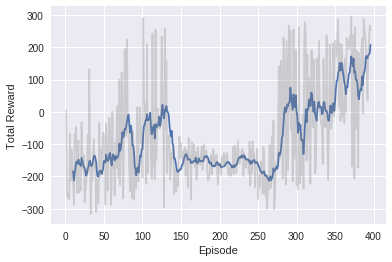

In [7]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews, lens = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Example 2: Continuous Actor-Critic **

In [0]:
# set up Actor and Critic networks

class ActorCriticNetwork:
  def __init__(self, name, action_low, action_high, obs_size=2, action_size=2, actor_hidden_size=32, ac_learning_rate=0.001, 
               entropy_cost=0.01, entropy_scale_op=None, lambda_=0., baseline_cost=1.):
    
    with tf.variable_scope(name):
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='inputs')
      self.action_ = tf.placeholder(tf.float32, [None, 1, action_size], name='action')
      self.reward_ = tf.placeholder(tf.float32, [None, 1], name='reward')
      self.discount_ = tf.placeholder(tf.float32, [None, 1], name='discount')
      self.bootstrap_ = tf.placeholder(tf.float32, [None], name='bootstrap')
      self.name=name
      
      #set up actor network
      self.fc1_mu_ = tf.contrib.layers.fully_connected(self.input_, actor_hidden_size, activation_fn=tf.nn.leaky_relu)
      self.fc2_mu_ = tf.contrib.layers.fully_connected(self.fc1_mu_, actor_hidden_size, activation_fn=tf.nn.leaky_relu)
      self.fc3_mu_ = tf.contrib.layers.fully_connected(self.fc2_mu_, action_size, activation_fn=tf.nn.tanh)
      
      self.fc1_scale_ = tf.contrib.layers.fully_connected(self.input_, actor_hidden_size, activation_fn=tf.nn.leaky_relu)
      self.fc2_scale_ = tf.contrib.layers.fully_connected(self.fc1_scale_, actor_hidden_size, activation_fn=tf.nn.leaky_relu)
      self.fc3_scale_ = tf.contrib.layers.fully_connected(self.fc2_scale_, action_size, activation_fn=tf.nn.sigmoid)
      self.scale_ = self.fc3_scale_*0.5 + 1e-5 
  
      self.distribution_ = tfp.distributions.MultivariateNormalDiag(loc=self.fc3_mu_, scale_diag=self.scale_)
      self.distribution_shaped_ = tfp.distributions.BatchReshape(distribution=self.distribution_, batch_shape=[-1,1])

      #generate actions by sampling from distributions and clipping them
      self.actions_scaled_ = tf.clip_by_value(self.distribution_shaped_.sample(), action_low, action_high) 
      
      #set up critic network
      self.fc1_critic_ = tf.contrib.layers.fully_connected(self.input_, critic_hidden_size, activation_fn=tf.nn.leaky_relu)
      self.fc2_critic_ = tf.contrib.layers.fully_connected(self.fc1_critic_, critic_hidden_size, activation_fn=tf.nn.leaky_relu)
      self.baseline_ = tf.contrib.layers.fully_connected(self.fc2_critic_, 1, activation_fn=None)
      
      #TRFL usage
      self.seq_aac_return_ = trfl.sequence_a2c_loss(self.distribution_shaped_, self.baseline_, self.action_,
         self.reward_, self.discount_, self.bootstrap_, lambda_=lambda_, entropy_cost=entropy_cost, 
         baseline_cost=baseline_cost, entropy_scale_op=entropy_scale_op)
      
      #Optimize the loss
      self.ac_loss_ = tf.reduce_mean(self.seq_aac_return_.loss)
      self.ac_optim_ = tf.train.AdamOptimizer(learning_rate=ac_learning_rate).minimize(self.ac_loss_)
      
  def get_network_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name+"/fully_connected_")]
            

** TRFL Usage: Continuous AC with trfl.sequence_a2c_loss **

Sequence A2C loss is the continuous A2C loss. The first argument is the policy distribution. The arguments: baseline, reward, discount, and bootstrap, and lambda are used to calculate the advantage. The entropy arguments are the same and used the same way as in trfl.policy_entropy_loss. baseline cost is an optional argument that lets you scale the derivative amount between the actor network and the critic network.






In [0]:
# hyperparameters
train_episodes = 5000    
discount = 0.99

actor_hidden_size = 32
critic_hidden_size = 32
ac_learning_rate = 0.0005
baseline_cost = 3. #scale derivatives between actor and critic networks

# entropy hyperparameters
entropy_cost = 0.005
entropy_scale_op = None

# one step returns ie TD(0). Section 4 will cover multi-step returns
lambda_ = 0.

seed = 31
env = gym.make('LunarLanderContinuous-v2')
env.seed(seed)
np.random.seed(seed)
action_size = env.action_space.shape[0]
obs_size = env.observation_space.shape[0]

tf.reset_default_graph()
tf.set_random_seed(seed)
ac_net = ActorCriticNetwork(name='ac_net', action_low=env.action_space.low[0], action_high=env.action_space.high[0], 
                            obs_size=obs_size, action_size=action_size, actor_hidden_size=actor_hidden_size,
                           ac_learning_rate=ac_learning_rate, entropy_cost=entropy_cost, entropy_scale_op=entropy_scale_op,
                            lambda_=lambda_, baseline_cost=baseline_cost)

ac_target_net = ActorCriticNetwork(name='ac_target_net', action_low=env.action_space.low[0], 
                                   action_high=env.action_space.high[0],
                                   obs_size=obs_size, action_size=action_size, actor_hidden_size=actor_hidden_size,
                           ac_learning_rate=ac_learning_rate, entropy_cost=entropy_cost, entropy_scale_op=entropy_scale_op,
                            lambda_=lambda_, baseline_cost=baseline_cost)

target_network_update_op = trfl.update_target_variables(ac_target_net.get_network_variables(), 
                                                         ac_net.get_network_variables(), tau=0.001)

In [10]:
stats_rewards_list = []
stats_every = 10

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
        total_reward, ep_length, done = 0, 0, 0
        total_loss_list = []
        
        state = np.clip(env.reset(), -1., 1.)
        
        if len(stats_rewards_list) > 10 and np.mean(stats_rewards_list[-10:],axis=0)[1] > 200:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(stats_rewards_list[-10:],axis=0)[1]))
          break
          
        while not done:       
            # generate action probabilities from policy net and sample from the action probs
            action = sess.run(ac_net.actions_scaled_, feed_dict={ac_net.input_: np.expand_dims(state,axis=0)})

            next_state, reward, done, info = env.step(action[0][0])
            next_state = np.clip(next_state,-1.,1.)
            total_reward += reward
            #reward *= .01
            ep_length += 1

            if done:
              bootstrap_value = np.zeros((1,),dtype=np.float32)
            else:
              #get bootstrap value
              bootstrap_value = sess.run(ac_target_net.baseline_, feed_dict={
                  ac_target_net.input_: np.expand_dims(next_state, axis=0)
              })
            
            #train network
            _, total_loss, = sess.run([ac_net.ac_optim_, ac_net.ac_loss_], feed_dict={
                ac_net.input_: np.expand_dims(state, axis=0),
                ac_net.action_: action,
                ac_net.reward_: np.reshape(reward, (-1, 1)),
                ac_net.discount_: np.reshape(discount, (-1, 1)),
                ac_net.bootstrap_: np.reshape(bootstrap_value, (1,))
            })
            total_loss_list.append(total_loss)
            
            #update target network
            sess.run(target_network_update_op)
            
            if total_reward < -250:
              done = 1
              
            if done:
              if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                      'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                      'Ep length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                      'Total loss: {:.4f}'.format(np.mean(total_loss_list)))
                total_loss_list = []
              stats_rewards_list.append((ep, total_reward, ep_length))
              break
              
            state = next_state
         

Episode: 10 Total reward: -245.7 Ep length: 87.4 Total loss: 177.9576
Episode: 20 Total reward: -214.1 Ep length: 120.5 Total loss: 68.0636
Episode: 30 Total reward: -246.8 Ep length: 128.1 Total loss: 100.4201
Episode: 40 Total reward: -197.7 Ep length: 110.1 Total loss: 129.0219
Episode: 50 Total reward: -224.4 Ep length: 110.7 Total loss: 97.1616
Episode: 60 Total reward: -217.7 Ep length: 144.8 Total loss: 98.5381
Episode: 70 Total reward: -227.8 Ep length: 140.7 Total loss: 114.8163
Episode: 80 Total reward: -207.7 Ep length: 147.6 Total loss: 9.8825
Episode: 90 Total reward: -253.7 Ep length: 150.5 Total loss: 53.7715
Episode: 100 Total reward: -260.3 Ep length: 201.9 Total loss: 50.7616
Episode: 110 Total reward: -154.2 Ep length: 194.8 Total loss: 47.2633
Episode: 120 Total reward: -118.5 Ep length: 178.7 Total loss: 145.1095
Episode: 130 Total reward: -216.0 Ep length: 183.9 Total loss: 37.2038
Episode: 140 Total reward: -196.8 Ep length: 263.1 Total loss: 8.6648
Episode: 150 

Text(0, 0.5, 'Total Reward')

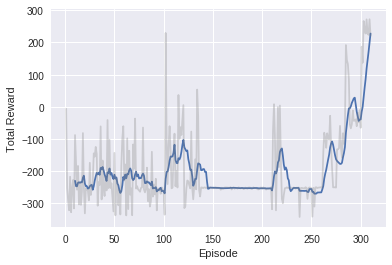

In [11]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews, lens = np.array(stats_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')